In [1]:
import scipy
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

In [2]:
# parameters
json_path = 'setting/C0016.json'
pattern_size = (15, 15)
square_size = 1
output_path = 'coords_voltages/coords_voltages_C0016.mat'
detection_path = 'detection_result/detection_result_C0016.mat'

f = open(json_path, 'r')
content = json.load(f)
voltage_path = content['voltage_path']
wall_board_time = content['wall_board_time']
spad_board_time = content['spad_board_time']
video_path = content['video_path']
time = wall_board_time
video = cv2.VideoCapture(video_path)

In [3]:
def get_video_frame(video, time):
    time *= 1000
    video.set(cv2.CAP_PROP_POS_MSEC, time) # gray scale image
    success, image = video.read()
    if success:
        return image
    return None

img = get_video_frame(video, time)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
imgpoints = []
objpoints = []

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(img, (15, 15), None)

# If found, add object points, image points (after refining them)
if ret == True:
    cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners)
    imgpoints = np.array(imgpoints)
    imgpoints_squeezed = np.squeeze(imgpoints)

In [8]:
np.flip(np.flip(np.mgrid[0:15, 0:15].T.reshape(-1, 2), axis=0), axis=1).shape

(225, 2)

In [6]:
objp = np.zeros((15*15, 3), np.float32)
objp[:, :2] = np.flip(np.flip(np.mgrid[0:15, 0:15].T.reshape(-1, 2), axis=0), axis=1)
objpoints.append(objp)
objpoints_squeezed = np.squeeze(np.array(objpoints))

retval, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [7]:
objpoints_squeezed.shape

(225, 3)

In [285]:
def img_to_world(img_coords, rvecs, tvecs, camera_matrix):
    
    """
    img_coords: (num_of_points, 2)
    rvecs, tvecs: tuple
    """

    img_coords = img_coords.T # (2, num_of_points) 
    img_coords = np.concatenate((img_coords, np.ones([1, img_coords.shape[1]])), axis=0) # (3, num_of_points) 
    
    # Transfer rotation vector to rotation matrix, and get translation matrix from tuple.
    R, _ = cv2.Rodrigues(rvecs[0])
    t = tvecs[0]

    scale = (np.linalg.inv(R) @ t)[2, :] / \
            (np.linalg.inv(R) @ np.linalg.inv(camera_matrix) @ img_coords)[2, :] # (1, num_of_points)
    
    world_coords = scale * (np.linalg.inv(R) @ np.linalg.inv(camera_matrix) @ img_coords) - np.linalg.inv(R) @ t
    
    return world_coords[:2, :] # (2, num_of_points), z = 0


In [284]:
def world_to_img(world_coords, rvecs, tvecs, camera_matrix):
    
    """
    world_coords: (num_of_points, 3)
    rvecs, tvecs: tuple
    """
    
    world_coords = world_coords.T # (3, num_of_points) 
    world_coords = np.concatenate((world_coords, np.ones([1, world_coords.shape[1]])), axis=0) # (4, num_of_points) 
    
    # Transfer rotation vector to rotation matrix, and get translation matrix from tuple.
    R, _ = cv2.Rodrigues(rvecs[0])
    t = tvecs[0]
    
    extrinsic = np.concatenate((R, t), axis=1)
    img_coords = camera_matrix @ extrinsic @ world_coords
    img_coords = img_coords / img_coords[2, :]
    img_coords = img_coords[:2, :] # (2, num_of_points)

    return img_coords # (2, num_of_points)


In [296]:
# img_to_world(imgpoints_squeezed, rvecs, tvecs, camera_matrix)
img_coords_inferred = world_to_img(objpoints_squeezed, rvecs, tvecs, camera_matrix)

In [325]:
R[:, None].shape

(3, 1, 3)

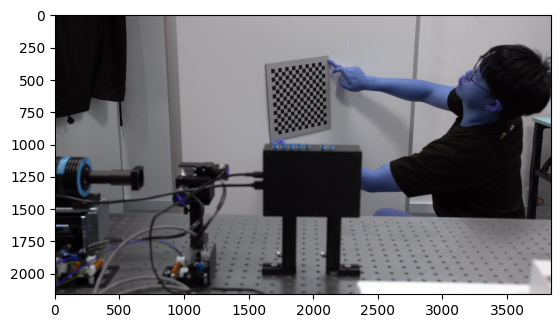

In [327]:
plt.imshow(img)

In [320]:
imgpoints_squeezed

array([[2059.8457 ,  402.18103],
       [2060.911  ,  433.1568 ],
       [2062.1775 ,  464.08652],
       [2063.1501 ,  494.8365 ],
       [2064.2197 ,  525.47235],
       [2065.3699 ,  555.9499 ],
       [2066.385  ,  586.3637 ],
       [2067.547  ,  616.6152 ],
       [2068.4521 ,  646.7825 ],
       [2069.6165 ,  676.58295],
       [2070.639  ,  706.62225],
       [2071.8093 ,  736.299  ],
       [2072.8916 ,  765.872  ],
       [2074.0657 ,  795.40674],
       [2074.9214 ,  824.8313 ],
       [2035.3248 ,  405.84286],
       [2036.5277 ,  436.89508],
       [2037.5878 ,  467.91058],
       [2038.7749 ,  498.73486],
       [2039.8215 ,  529.6914 ],
       [2040.9119 ,  559.87744],
       [2042.2633 ,  590.5108 ],
       [2043.3411 ,  620.9845 ],
       [2044.4663 ,  651.18225],
       [2045.5688 ,  681.3089 ],
       [2046.6296 ,  711.3436 ],
       [2047.8907 ,  741.0618 ],
       [2048.9583 ,  770.84863],
       [2050.06   ,  800.38086],
       [2051.3047 ,  829.89966],
       [20

In [295]:
img_to_world(imgpoints_squeezed, rvecs, tvecs, camera_matrix)[:, 4]

array([ 3.93967486, -0.02277957])

<function matplotlib.pyplot.show(close=None, block=None)>

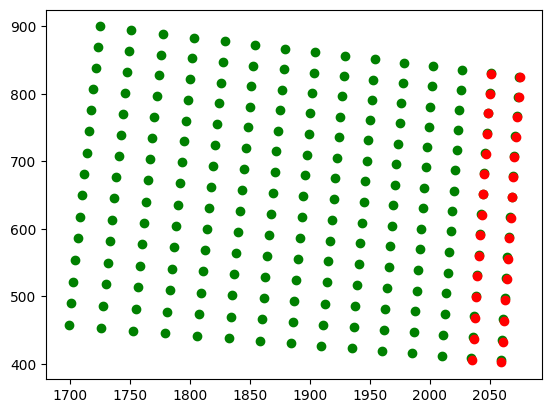

In [310]:
plt.scatter(img_coords_inferred[0, :], img_coords_inferred[1, :], c='g')
plt.scatter(imgpoints_squeezed.T[0, :15], imgpoints_squeezed.T[1, :15], c='r')
plt.scatter(imgpoints_squeezed.T[0, 15:30], imgpoints_squeezed.T[1, 15:30], c='r')
plt.show

In [293]:
objpoints_squeezed[4, :]

array([4., 0., 0.], dtype=float32)